In [41]:
import os
import cv2 as cv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications import ResNet50 , ResNet101, ResNet152


# 한글 깨짐 방지
plt.rc('font', family='AppleGothic') 
plt.rcParams['axes.unicode_minus'] = False 

In [18]:
###################################################### 실행 안함. 자동완성용

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
######################################################

In [45]:
## 함수

def imgProcess(img):
    resize = cv.resize(img, (400,400), interpolation=cv.INTER_CUBIC)
    gray = cv.cvtColor(resize, cv.COLOR_BGR2GRAY)
    threshold, thresh = cv.threshold(gray,152, 255, cv.THRESH_BINARY)
    blur = cv.GaussianBlur(thresh,(3,3), cv.BORDER_DEFAULT)
    img_canny = cv.Canny(blur , 50, 100)
    img_dilated = cv.dilate(img_canny, (3, 3), iterations=3)
    img_eroded = cv.erode(img_dilated, (3, 3), iterations=3)
    return img_eroded


## 전역

folder_list = os.listdir('/Users/jsp/Desktop/workspace/projects/fstteamproject/main/git_teamprj/proj1/open/train')
folder_list.remove('.DS_Store') 
data = []
pic_count = []


## 메인

for folder_name in folder_list:
    folder_path = '/Users/jsp/Desktop/workspace/projects/fstteamproject/main/git_teamprj/proj1/open/train/' + folder_name
  
    image_list = os.listdir(folder_path)
    list_len = len(image_list)
    pic_count.append(list_len)
    
    for image_name in image_list:
        image_path = folder_path +'/' + image_name
        img = cv.imread(image_path)
        data.append(imgProcess(img))
        
        
answer = []
for idx, nm in enumerate(folder_list):
        answer += [nm] * pic_count[idx]

Text(0.5, 1.0, '훼손')

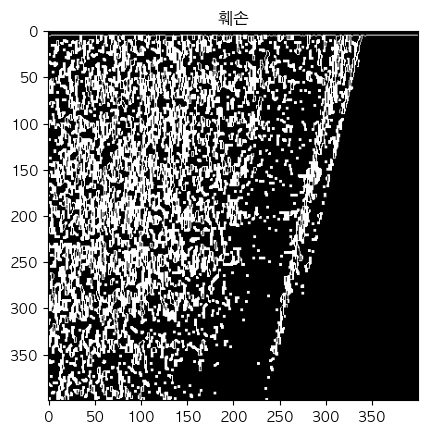

In [47]:
num = 3440
plt.imshow(data[num], cmap='gray')
plt.title(answer[num])

In [48]:
vcount = pd.DataFrame(answer).value_counts()
vcount = pd.DataFrame(vcount).reset_index().rename(columns={0 : 'class'})
fig = px.bar(vcount, x= vcount['class'], y=vcount['count'], text=vcount['count'])
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8)

In [49]:
answer = np.array(answer)
answer = pd.get_dummies(answer)
answer = answer.values

In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(data),answer,test_size=0.2, shuffle=True)
print(xtrain.shape)
print(xtest.shape)
xtrain = xtrain.reshape(2765,400,400,1).astype('float32')/255
xtest = xtest.reshape(692,400,400,1).astype('float32')/255

(2765, 400, 400)
(692, 400, 400)


In [53]:
model = Sequential()
model.add(ResNet50(weights=None, include_top=None, input_shape=(400,400,1)))
model.add(Dense(128,activation = 'leaky_relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation = 'leaky_relu'))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(19, activation = 'softmax'))

model.summary()
model.compile(optimizer= 'adam', loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 13, 2048)      23581440  
                                                                 
 dense_5 (Dense)             (None, 13, 13, 128)       262272    
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 128)       0         
                                                                 
 dense_6 (Dense)             (None, 13, 13, 64)        8256      
                                                                 
 flatten_3 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_4 (Dropout)         (None, 10816)             0         
                                                                 
 dense_7 (Dense)             (None, 19)               

In [54]:
modelpath="resnet50_bestmodel.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [55]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,
        rotation_range=5,  
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=True, 
        vertical_flip=True) 

datagen.fit(xtrain)

In [56]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=50), validation_data=(xtest, ytest), epochs = 200, verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/200
56/56 [==============================] - 396s 7s/step - loss: 3.1571 - accuracy: 0.3204 - val_loss: 2.2990 - val_accuracy: 0.4147
Epoch 2/200
56/56 [==============================] - 381s 7s/step - loss: 2.4082 - accuracy: 0.3689 - val_loss: 29.7203 - val_accuracy: 0.4147
Epoch 3/200
56/56 [==============================] - 376s 7s/step - loss: 2.4132 - accuracy: 0.3946 - val_loss: 2.0864 - val_accuracy: 0.4147
Epoch 4/200
56/56 [==============================] - 366s 7s/step - loss: 2.5134 - accuracy: 0.3852 - val_loss: 3.2711 - val_accuracy: 0.4147
Epoch 5/200
56/56 [==============================] - 396s 7s/step - loss: 2.3853 - accuracy: 0.3881 - val_loss: 12.8453 - val_accuracy: 0.2803
Epoch 6/200
56/56 [==============================] - 377s 7s/step - loss: 2.3044 - accuracy: 0.4047 - val_loss: 13.2711 - val_accuracy: 0.3801
Epoch 7/200
56/56 [==============================] - 384s 7s/step - loss: 2.1867 - accuracy: 0.4036 - val_loss: 9.9304 - val_accuracy: 0.2905
Epo

KeyboardInterrupt: 

In [31]:
my_model = load_model('resnet50_bestmodel.hdf5')
score = my_model.evaluate(xtest, ytest)
print('Test accuracy:', score[1])

22/22 [==============================] - 10s 411ms/step - loss: 2.3338 - accuracy: 0.4234
Test accuracy: 0.42341041564941406


22/22 [==============================] - 9s 393ms/step


Text(70.72222222222221, 0.5, 'true label')

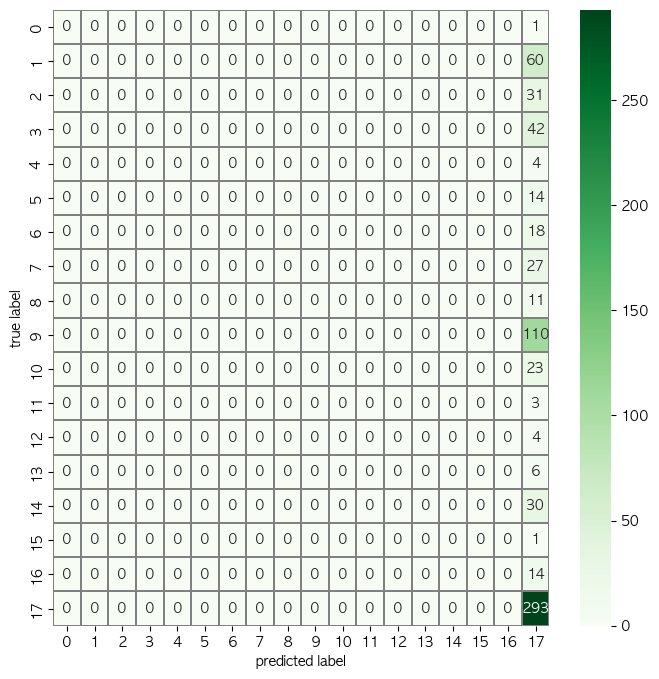

In [33]:
y_pred = my_model.predict(xtest)
y_pred_cls = np.argmax(y_pred,1)
y_true = np.argmax(ytest, axis=1)

cmat = confusion_matrix(y_true,y_pred_cls)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(cmat, annot=True, linewidths=0.01,cmap="coolwarm",linecolor="gray", fmt= '1d',ax=ax)
plt.xlabel('predicted label')
plt.ylabel('true label')

In [36]:
# submit format /// 이미지 자체를 test 값으로 집어 넣을 경우의 code
# test.csv가 있기 때문에 이걸 이용해서 간단하게 경로를 지정해서 이미지를 변환 할 수도 있다.
test_data = []
test_folder_path = '/Users/jsp/Desktop/workspace/projects/fstteamproject/main/git_teamprj/proj1/open/test/'

image_list = os.listdir(test_folder_path)
list_len = len(image_list)
pic_count.append(list_len)

for test_image_name in image_list:
    test_image_path = test_folder_path +'/' + test_image_name
    test_img = cv.imread(test_image_path)
    test_data.append(imgProcess(test_img))


final_pred = my_model.predict(np.array(test_data))

25/25 [==============================] - 11s 411ms/step


In [38]:
final_test_pred=np.argmax(final_pred,axis=1)
submit=pd.read_csv('/Users/jsp/Desktop/workspace/projects/fstteamproject/main/git_teamprj/proj1/open/sample_submission.csv')
submit_result = pd.DataFrame({'id': submit['id'], 'label': final_test_pred})
submit_result['label'] = submit_result['label'].map(dict(zip(range(19),folder_list)))
submit_result.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv') # 제출할 목록 내용 빠르게 확인

,id,label
0,TEST_000,틈새과다
1,TEST_001,틈새과다
2,TEST_002,틈새과다
3,TEST_003,틈새과다
4,TEST_004,틈새과다
...,...,...
787,TEST_787,틈새과다
788,TEST_788,틈새과다
789,TEST_789,틈새과다
790,TEST_790,틈새과다
